## ✒️ Code Modules

In [3]:
from IPython.display import display,HTML
from IPython.core.magic import register_line_magic
import tensorflow as tf,tensorflow_hub as hub,numpy as np
import os,h5py,urllib,pylab as pl
file_path='https://raw.githubusercontent.com/'+\
           'OlgaBelitskaya/data_kitchen/main/'
file_name='HorseBreeds160.h5'
img_size=int(64)

## ✒️  Image Data

In [5]:
def get_data(file_path,file_name,img_size):
    input_file=urllib.request.urlopen(file_path+file_name)
    output_file=open(file_name,'wb')
    output_file.write(input_file.read())
    output_file.close(); input_file.close()
    with h5py.File(file_name,'r') as f:
        keys=list(f.keys())
        print('file keys: '+', '.join(keys))
        images=np.array(f[keys[0]])
        images=tf.image.resize(images,[img_size,img_size]).numpy()
        labels=np.array(f[keys[1]])
        names=[el.decode('utf-8')for el in f[keys[2]]]
        f.close()
    return images,labels,names
images,labels,names=get_data(file_path,file_name,img_size)

file keys: images, labels, names


## ✒️ Super Resolution

In [14]:
def esrgantf2_superresolution(img,img_size=64):
    model=hub.load('https://tfhub.dev/captain-pool/esrgan-tf2/1')
    func=model.signatures[tf.saved_model.DEFAULT_SERVING_SIGNATURE_DEF_KEY]
    func.inputs[0].set_shape([1,img_size,img_size,3])
    converter=tf.lite.TFLiteConverter.from_concrete_functions([func])
    converter.optimizations=[tf.lite.Optimize.DEFAULT]
    tflite_model=converter.convert()
    with tf.io.gfile.GFile('ESRGAN.tflite','wb') as f:
        f.write(tflite_model)
    esrgan_model_path='./ESRGAN.tflite'
    if img.mean()<1: img=img*255
    lr=tf.image.resize(img,[img_size,img_size])
    lr=tf.expand_dims(lr.numpy()[:,:,:3],axis=0)
    lr=tf.cast(lr,tf.float32)
    interpreter=tf.lite.Interpreter(model_path=esrgan_model_path)
    interpreter.allocate_tensors()
    input_details=interpreter.get_input_details()
    output_details=interpreter.get_output_details()
    interpreter.set_tensor(input_details[0]['index'],lr)
    interpreter.invoke()
    output_data=interpreter.get_tensor(output_details[0]['index'])
    sr=tf.squeeze(output_data,axis=0)
    sr=tf.clip_by_value(sr,0,255)
    sr=tf.round(sr); sr=tf.cast(sr,tf.uint8)
    lr=tf.cast(tf.squeeze(lr,axis=0),tf.uint8)
    return lr,sr
lr,sr=esrgantf2_superresolution(images[0])

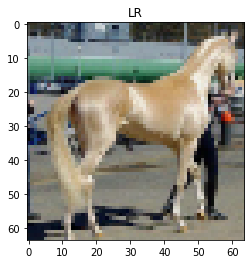

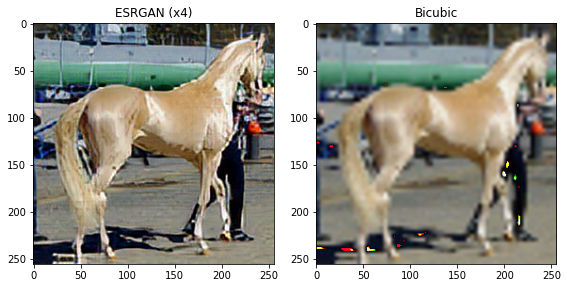

In [17]:
def low2superbicubic_imgs(lr,sr):
    pl.figure(figsize=(8,4)); pl.title('LR')
    pl.imshow(lr.numpy()); pl.show(); print()
    pl.figure(figsize=(8,4))
    pl.subplot(1,2,1); pl.title(f'ESRGAN (x4)')
    pl.imshow(sr.numpy());
    img_size=lr.shape[1]
    bicubic=tf.image.resize(
        lr,[img_size*4,img_size*4],tf.image.ResizeMethod.BICUBIC)
    bicubic=tf.cast(bicubic, tf.uint8)
    pl.subplot(1,2,2); pl.title('Bicubic')
    pl.imshow(bicubic.numpy())
    pl.tight_layout(); pl.show()
low2superbicubic_imgs(lr,sr)